# Imports

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import (
    ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
)
from pathlib import Path
import json, chess, chess.pgn, io

# Paths of data and for logs in Tensorboard

In [21]:
BASE_DIR = Path().resolve().parent

ART_DIR  = BASE_DIR / "artifacts"
DATA_DIR = BASE_DIR / "data"
CKPT_DIR = ART_DIR / "ckpts"
LOG_DIR  = BASE_DIR / "logs"

CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

print("Base Directory :", BASE_DIR)
print("Artifacts Dir  :", ART_DIR)
print("Data Dir       :", DATA_DIR)
print("Checkpoints    :", CKPT_DIR)
print("Logs Dir       :", LOG_DIR)
print("Dataset Path   :", ART_DIR / "dataset_improved.npz")


Base Directory : C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel
Artifacts Dir  : C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\artifacts
Data Dir       : C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\data
Checkpoints    : C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\artifacts\ckpts
Logs Dir       : C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\logs
Dataset Path   : C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\artifacts\dataset_improved.npz


## Constants

In [22]:
NUM_CLASSES     = 1629
INPUT_CHANNELS  = 18
BATCH_SIZE      = 128
EPOCHS          = 80
SMOOTHING       = 0.05
L2_REG          = 1e-4
MASK_CACHE_PATH = ART_DIR / "dataset_with_masks.npz"
VOCAB_PATH      = ART_DIR / "vocab_improved.json"

# Automatically detects PGN files in data folder
PGN_FILES = list(DATA_DIR.glob("*.pgn"))
if not PGN_FILES:
    print(" No PGN files found in data folder.")
else:
    print(" Found PGN files:", [p.name for p in PGN_FILES])


 Found PGN files: ['lichess_Sahil_Rana_2025-11-08.pgn', 'lichess_Vis_2025-11-08.pgn']


# Custom Layers + Blocks

In [23]:
class MaskedAdd(layers.Layer):
    def call(self, inputs):
        logits, mask = inputs
        return logits + tf.math.log(mask + 1e-9)

def se_block(t, r=8):
    c = int(t.shape[-1])
    s = layers.GlobalAveragePooling2D()(t)
    s = layers.Dense(max(1, c // r), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    s = layers.Reshape((1, 1, c))(s)
    return layers.Multiply()([t, s])

def res_block(x, filters=128, reg=None):
    skip = layers.Conv2D(filters, 3, padding="same", kernel_regularizer=reg)(x)

    y = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_regularizer=reg)(x)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.2)(y)

    y = layers.Conv2D(filters, 3, padding="same", kernel_regularizer=reg)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.2)(y)

    y = se_block(y)
    return layers.Activation("relu")(layers.Add()([skip, y]))


def make_masked_resnet(num_classes, input_channels, reg=None):
    x_inp   = layers.Input(shape=(8, 8, input_channels), name="x_inp")
    mask_in = layers.Input(shape=(num_classes,), name="mask_inp")

    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_regularizer=reg)(x_inp)
    x = layers.BatchNormalization()(x)
    for _ in range(3):
        x = res_block(x, 128, reg)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(0.6)(x)
    logits = layers.Dense(num_classes, name="logits")(x)
    out = MaskedAdd(name="masked_logits")([logits, mask_in])
    return models.Model(inputs=[x_inp, mask_in], outputs=out)

class MaskedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, smooth=0.05, name="masked_sce", **kwargs):
        super().__init__(name=name, **kwargs)
        self.smooth = smooth

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        c = tf.shape(y_pred)[-1]
        y_true_oh = tf.one_hot(y_true, c, dtype=tf.float32)
        y_true_oh = (1.0 - self.smooth) * y_true_oh + self.smooth / tf.cast(c, tf.float32)
        return tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y_true_oh, y_pred, from_logits=True)
        )


# PGN → arrays

In [24]:
def piece_to_channel(piece):
    piece_types = {'P':0, 'N':1, 'B':2, 'R':3, 'Q':4, 'K':5}
    base = piece_types[piece.symbol().upper()]
    return base if piece.color else base + 6

def board_to_planes(board, input_channels):
    planes = np.zeros((8, 8, input_channels), dtype=np.float32)
    piece_map = board.piece_map()
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        planes[row, col, piece_to_channel(piece)] = 1.0
    return planes

def parse_pgn_to_arrays(pgn_path, vocab_path, input_channels=18):
    if not Path(pgn_path).exists():
        return None
    print(f" Parsing PGN: {pgn_path.name}")
    with open(vocab_path, "r") as f:
        move_to_id = json.load(f)
    X_list, y_list, fen_list = [], [], []
    with open(pgn_path, "r", encoding="utf-8") as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            board = game.board()
            for move in game.mainline_moves():
                X_list.append(board_to_planes(board, input_channels))
                fen_list.append(board.fen())
                y_list.append(move_to_id.get(move.uci(), 0))
                board.push(move)
    print(f" Parsed {len(X_list)} positions.")
    return np.array(X_list, np.float32), np.array(y_list, np.int32), np.array(fen_list, object)


# Build masks from FENs

In [25]:
def build_masks_from_fens(fens, num_classes, vocab_path):
    with open(vocab_path, "r") as f:
        move_to_id = json.load(f)

    def mask_from_fen(fen):
        board = chess.Board(fen)
        mask = np.zeros((num_classes,), dtype=np.float32)
        for mv in board.legal_moves:
            idx = move_to_id.get(mv.uci(), None)
            if idx is not None and 0 <= idx < num_classes:
                mask[idx] = 1.0
        if mask.sum() == 0:
            mask[:] = 1.0
        return mask

    print("Building legality masks...")
    masks = np.stack([mask_from_fen(f) for f in fens]).astype(np.float32)
    return masks

# Load and Merge Datasets

In [26]:
print("\n Loading base dataset...")
base = np.load(ART_DIR / "dataset_improved.npz", allow_pickle=True)
X_old, y_old, fens_old = base["X"], base["y"], base["fens"]
print(f" Base: {X_old.shape}")

merged_X, merged_y, merged_fens = [X_old], [y_old], [fens_old]
for pgn_file in PGN_FILES:
    parsed = parse_pgn_to_arrays(pgn_file, VOCAB_PATH)
    if parsed:
        X_new, y_new, fens_new = parsed
        merged_X.append(X_new)
        merged_y.append(y_new)
        merged_fens.append(fens_new)

X = np.concatenate(merged_X, axis=0)
y = np.concatenate(merged_y, axis=0)
fens = np.concatenate(merged_fens, axis=0)

print(f"🧩 Combined dataset: {X.shape}")


 Loading base dataset...
 Base: (20806, 8, 8, 18)
 Parsing PGN: lichess_Sahil_Rana_2025-11-08.pgn
 Parsed 20821 positions.
 Parsing PGN: lichess_Vis_2025-11-08.pgn
 Parsed 5424 positions.
🧩 Combined dataset: (47051, 8, 8, 18)


# Masks + Split + Datasets

In [27]:
print("\n Shuffling dataset before splitting...")
idx = np.random.permutation(len(X))

X = X[idx]
y = y[idx]
fens = fens[idx]
M = M[idx]

# Split after shuffle
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
M_train, M_val = M[:split_idx], M[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices(((X_train, M_train), y_train)).shuffle(8192).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val, M_val), y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)


 Shuffling dataset before splitting...


# Model + Optimizer + Training

In [28]:
steps_per_epoch = max(1, len(X_train) // BATCH_SIZE)
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=3e-4,
    first_decay_steps=steps_per_epoch * 5,
    t_mul=2.0,
    m_mul=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
reg = tf.keras.regularizers.l2(L2_REG)

model = make_masked_resnet(NUM_CLASSES, INPUT_CHANNELS, reg=reg)
model.compile(
    optimizer=optimizer,
    loss=MaskedSparseCategoricalCrossentropy(SMOOTHING),
    metrics=[
        "sparse_categorical_accuracy",
        SparseTopKCategoricalAccuracy(k=5),
        SparseTopKCategoricalAccuracy(k=10),
        SparseTopKCategoricalAccuracy(k=20),
    ],
)

checkpoint_path = CKPT_DIR / "final_trained_model.keras"
callbacks = [
    ModelCheckpoint(filepath=str(checkpoint_path), monitor="val_sparse_categorical_accuracy", save_best_only=True, verbose=1),
    TensorBoard(log_dir=str(LOG_DIR), histogram_freq=1),
    EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=6, restore_best_weights=True),
]

print("\n Training on combined dataset...")
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)



 Training on combined dataset...
Epoch 1/80
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 3.9040 - sparse_categorical_accuracy: 0.5416 - sparse_top_k_categorical_accuracy: 0.5676 - sparse_top_k_categorical_accuracy_1: 0.5865 - sparse_top_k_categorical_accuracy_2: 0.6148
Epoch 1: val_sparse_categorical_accuracy improved from None to 0.56328, saving model to C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\artifacts\ckpts\final_trained_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 68s 204ms/step - loss: 3.4349 - sparse_categorical_accuracy: 0.5650 - sparse_top_k_categorical_accuracy: 0.5987 - sparse_top_k_categorical_accuracy_1: 0.6231 - sparse_top_k_categorical_accuracy_2: 0.6579 - val_loss: 4.2385 - val_sparse_categorical_accuracy: 0.5633 - val_sparse_top_k_categorical_accuracy: 0.6035 - val_sparse_top_k_categorical_accuracy_1: 0.6320 - val_sparse_top_k_categorical_accuracy_2: 0.6687
Epoch 2/80
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 3.1434 - sparse_categorical_accur

# Evaluation + Plots


 Evaluating model...
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 3.1819 - sparse_categorical_accuracy: 0.5964 - sparse_top_k_categorical_accuracy: 0.6468 - sparse_top_k_categorical_accuracy_1: 0.6804 - sparse_top_k_categorical_accuracy_2: 0.7162
loss: 3.1819
compile_metrics: 0.5964

 Saved accuracy and loss plots to C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\artifacts
 Final model saved to: C:\Users\abhay\OneDrive\Desktop\Pyhton + AI\chessmodel\artifacts\ckpts\final_trained_model.keras

Retraining completed successfully with new data!


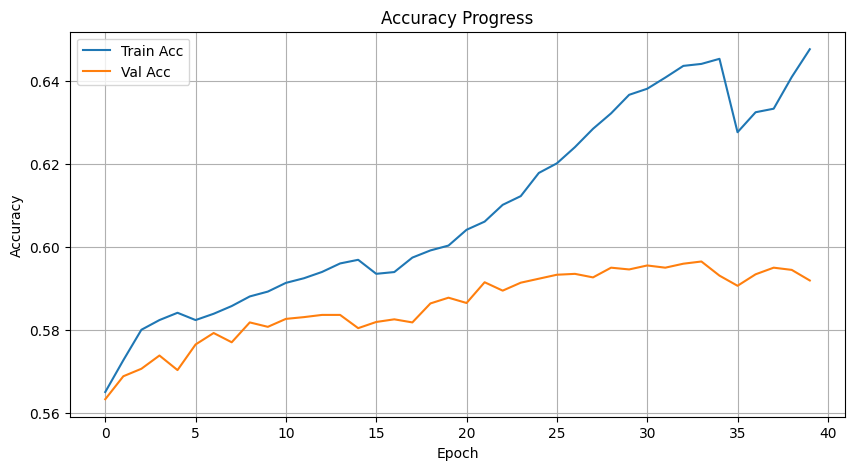

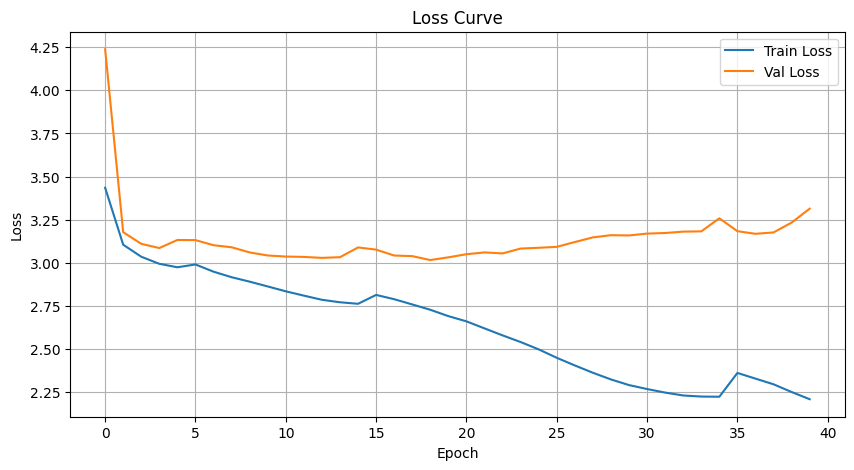

In [29]:
print("\n Evaluating model...")
results = model.evaluate(val_ds, verbose=1)
metric_names = model.metrics_names
for name, value in zip(metric_names, results):
    print(f"{name}: {value:.4f}")

plt.figure(figsize=(10,5))
plt.plot(history.history["sparse_categorical_accuracy"], label="Train Acc")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="Val Acc")
plt.title("Accuracy Progress")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(ART_DIR / "accuracy_plot.png")

plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(ART_DIR / "loss_plot.png")

print(f"\n Saved accuracy and loss plots to {ART_DIR}")
print(f" Final model saved to: {checkpoint_path}")
print("\nRetraining completed successfully with new data!")
